# NERSC Cluster Deploy Tutorial: PyTorch MNIST Example - Ray + Horovod

📖 [Back to Table of Contents](./README.md)<br>
⬅ [Previous notebook](./ex_01_ray_cluster_pi.ipynb) <br>
<!-- ➡ [Next notebook](./ex_02_pytorch_ray_hvd.ipynb) <br> -->


----


## Introduction

We are going to run a simple PyTorch MNIST example. We will train the model distributed using horovod on a Ray cluster. This tutorial is following the code in this example https://docs.ray.io/en/latest/train/examples/horovod/horovod_example.html

> **Note**:
> To setup the environment for the notebook, execute on command line: `./setup.sh 2` then select the kernel `nersc_pytorch_ngc-22.09-v0` in the notebook

This Ray cluster will be setup using the NERSC pytorch Nvidia NGC container image `nersc/pytorch:ngc-22.09-v0` and deployed on Perlmutter.



# Starting Ray Cluster

## Superfacility API

To deploy the Ray cluster via the NERSC Superfacility API you require a valid API client. 

To create a valid client visit your profile page in [Iris](https://iris.nersc.gov/):

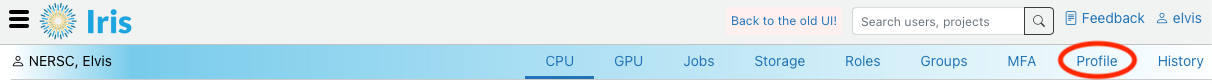

Then scroll down to the **Superfacility API Clients** section and click the "+ New Client" button which will produce this window:

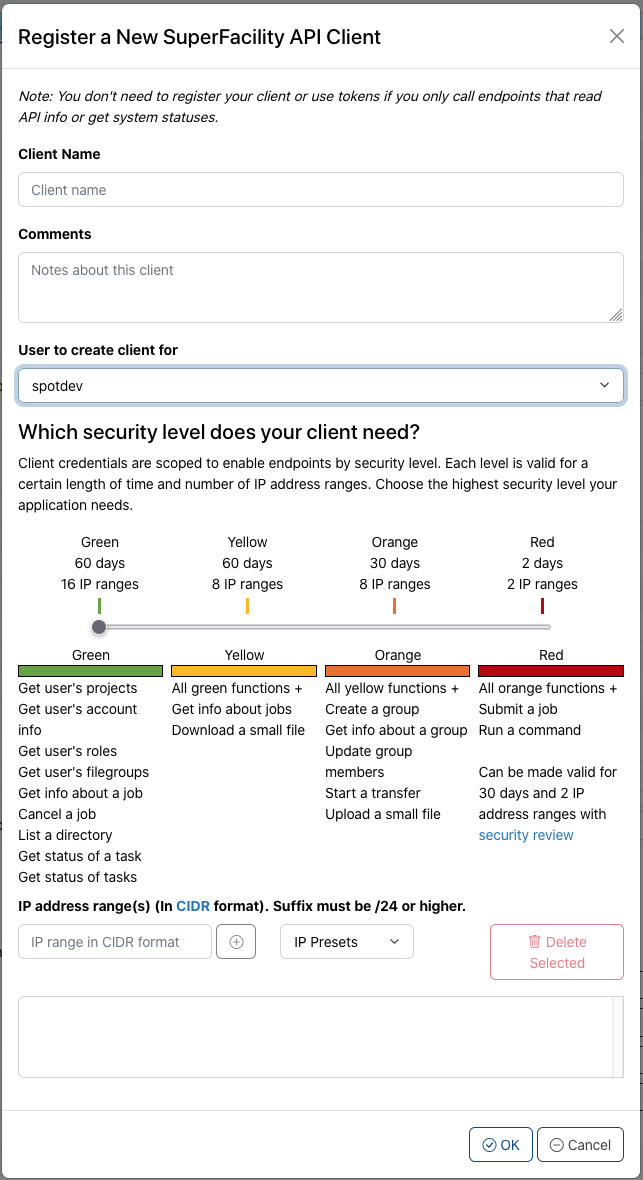

To submit and deploy a Ray cluster we require the highest security level (<span style="color:red">RED</span>). **[This client id is valid for 2 days]**

Once created then saved the `client_id` string and `private_key` dictionary (you can also save the private key in PEM format) ready for use with the `SuperfacilityAPI` library.

> **Note**:
> This step should only be repeated if your client has expired


For more information about the NERSC Superfacility API visit the [documenation](https://docs.nersc.gov/services/sfapi/).

In [23]:
from SuperfacilityAPI import SuperfacilityAPI, SuperfacilityAccessToken
from utility import load_secrets

# Replace with your client id string and private key dictionary
client_id, private_key = load_secrets()
# client_id = "<your client id string>"
# private_key = "<your private key dict>"

api_key = SuperfacilityAccessToken(
    client_id = client_id,
    private_key = private_key
)
sfp_api = SuperfacilityAPI(api_key)

## Creating Ray Cluster

To create a ray cluster on NERSC compute nodes, execute the `deploy_ray_cluster` function with your desired slurm sbatch options.

In [24]:
from nersc_cluster_deploy import deploy_ray_cluster
from utility import user_account

slurm_options = {
    'qos': 'debug',
    'account': user_account(),
    'image': 'nersc/pytorch:ngc-22.09-v0',
    'module': 'gpu,nccl-2.15',
    'nodes': '2',
    't': '00:30:00'
}
site = 'perlmutter'

JUPYTER_KERNEL="nersc_pytorch_ngc-22.09-v0"
job = deploy_ray_cluster(
    sfp_api,
    slurm_options,
    site,
    job_setup = [f'export PYTHONUSERBASE=$HOME/.local/perlmutter/{JUPYTER_KERNEL}'],
    srun_flags = '--mpi=pmi2'
)

In [25]:
job

{'error': None, 'jobid': '5648836', 'task_id': '9492'}

Now the job has been submitted, check on the job status

In [31]:
import os
import pandas as pd
sqs_table = sfp_api.get_jobs(site=site, user=os.getlogin(), sacct=False)
sqs_df = pd.DataFrame(sqs_table['output'])
sqs_df

,account,tres_per_node,min_cpus,min_tmp_disk,end_time,features,group,over_subscribe,jobid,name,...,partition,nodelist(reason),start_time,state,uid,submit_time,licenses,core_spec,schednodes,work_dir
0,dasrepo_g,N/A,128,0,2023-02-21T15:17:08,gpu&a100&hbm40g,75235,NO,5648836,sbatch,...,gpu_ss11,"nid[003940,008292]",2023-02-21T14:47:08,RUNNING,75235,2023-02-21T14:39:51,u2:1,N/A,(null),/global/u2/a/asnaylor


Check job log

In [32]:
!cat ~/slurm-5648836.out

[slurm] - Starting ray HEAD
2023-02-21 22:47:16,532	INFO usage_lib.py:452 -- Usage stats collection is disabled.
2023-02-21 22:47:16,532	INFO scripts.py:719 -- Local node IP: nid003940
2023-02-21 22:47:18,685	SUCC scripts.py:756 -- --------------------
2023-02-21 22:47:18,686	SUCC scripts.py:757 -- Ray runtime started.
2023-02-21 22:47:18,686	SUCC scripts.py:758 -- --------------------
2023-02-21 22:47:18,686	INFO scripts.py:760 -- Next steps
2023-02-21 22:47:18,686	INFO scripts.py:761 -- To connect to this Ray runtime from another node, run
2023-02-21 22:47:18,686	INFO scripts.py:764 --   ray start --address='nid003940:6379'
2023-02-21 22:47:18,686	INFO scripts.py:780 -- Alternatively, use the following Python code:
2023-02-21 22:47:18,686	INFO scripts.py:782 -- import ray
2023-02-21 22:47:18,686	INFO scripts.py:786 -- ray.init(address='auto', _node_ip_address='nid003940')
2023-02-21 22:47:18,686	INFO scripts.py:798 -- To connect to this Ray runtime from outside of the cluster, for ex

## Connect to Ray Cluster

Get the Ray cluster head node ip address to connect to the cluster

In [33]:
from nersc_cluster_deploy import get_ray_cluster_address
import ray

cluster_address = get_ray_cluster_address(
    sfp_api,
    job['jobid'],
    site
)
ray.init(cluster_address)

Python version:,3.8.13
Ray version:,2.0.0


Check all nodes connected to cluster

In [34]:
from nersc_cluster_deploy import ray_cluster_summary

ray_cluster_summary()

Cluster Summary
---------------
Nodes: 2
CPU:   256
GPU:   8
RAM:   317.26 GB


## Setup PyTorch Model

In [35]:
import argparse
import os

import horovod.torch as hvd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data.distributed
from filelock import FileLock
from torchvision import datasets, transforms

import ray
from ray.air import session
from ray.train.horovod import HorovodTrainer
from ray.air.config import ScalingConfig

In [36]:
def metric_average(val, name):
    tensor = torch.tensor(val)
    avg_tensor = hvd.allreduce(tensor, name=name)
    return avg_tensor.item()


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [37]:
def setup(config):
    data_dir = config.get("data_dir", None)
    seed = config.get("seed", 42)
    batch_size = config.get("batch_size", 64)
    use_adasum = config.get("use_adasum", False)
    lr = config.get("lr", 0.01)
    momentum = config.get("momentum", 0.5)
    use_cuda = config.get("use_cuda", False)

    # Horovod: initialize library.
    hvd.init()
    torch.manual_seed(seed)

    if use_cuda:
        # Horovod: pin GPU to local rank.
        torch.cuda.set_device(hvd.local_rank())
        torch.cuda.manual_seed(seed)

    # Horovod: limit # of CPU threads to be used per worker.
    torch.set_num_threads(1) #does this need to be set

    kwargs = {"num_workers": 1, "pin_memory": True} if use_cuda else {}
    data_dir = data_dir or "~/data"
    with FileLock(os.path.expanduser("~/.horovod_lock")):
        train_dataset = datasets.MNIST(
            data_dir,
            train=True,
            download=True,
            transform=transforms.Compose(
                [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
            ),
        )
    # Horovod: use DistributedSampler to partition the training data.
    train_sampler = torch.utils.data.distributed.DistributedSampler(
        train_dataset, num_replicas=hvd.size(), rank=hvd.rank()
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler, **kwargs
    )

    model = Net()

    # By default, Adasum doesn't need scaling up learning rate.
    lr_scaler = hvd.size() if not use_adasum else 1

    if use_cuda:
        # Move model to GPU.
        model.cuda()
        # If using GPU Adasum allreduce, scale learning rate by local_size.
        if use_adasum and hvd.nccl_built():
            lr_scaler = hvd.local_size()

    # Horovod: scale learning rate by lr_scaler.
    optimizer = optim.SGD(model.parameters(), lr=lr * lr_scaler, momentum=momentum)

    # Horovod: wrap optimizer with DistributedOptimizer.
    optimizer = hvd.DistributedOptimizer(
        optimizer,
        named_parameters=model.named_parameters(),
        op=hvd.Adasum if use_adasum else hvd.Average,
    )

    return model, optimizer, train_loader, train_sampler

In [38]:
def train_epoch(
    model, optimizer, train_sampler, train_loader, epoch, log_interval, use_cuda
):
    loss = None
    model.train()
    # Horovod: set epoch to sampler for shuffling.
    train_sampler.set_epoch(epoch)
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            # Horovod: use train_sampler to determine the number of
            # examples in this worker's partition.
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_sampler),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )
    return loss.item() if loss else None


In [39]:
def train_func(config):
    num_epochs = config.get("num_epochs", 10)
    log_interval = config.get("log_interval", 10)
    use_cuda = config.get("use_cuda", False)

    model, optimizer, train_loader, train_sampler = setup(config)

    for epoch in range(num_epochs):
        loss = train_epoch(
            model, optimizer, train_sampler, train_loader, epoch, log_interval, use_cuda
        )
        session.report(dict(loss=loss))


## Train Model

In [46]:
SCRATCH = os.getenv('SCRATCH')

node_resources = ray.cluster_resources()
num_workers = int(node_resources['GPU'])
use_cuda = True

kwargs = {
        "data_dir": os.path.join(SCRATCH, 'MNIST'),
        "seed": 42,
        "use_cuda": use_cuda,
        "batch_size": 64,
        "use_adasum": False,
        "lr": 0.01,
        "momentum": 0.5,
        "num_epochs": 20,
        "log_interval": 500,
    }

In [47]:
trainer = HorovodTrainer(
        train_func,
        train_loop_config=kwargs,
        scaling_config=ScalingConfig(use_gpu=use_cuda, num_workers=num_workers),
    )
results = trainer.fit()
print(results.metrics)

(TunerInternal pid=80502) 2023-02-21 22:51:33,839	WARNING trial_runner.py:328 -- The maximum number of pending trials has been automatically set to the number of available cluster CPUs, which is high (281 CPUs/pending trials). If you're running an experiment with a large number of trials, this could lead to scheduling overhead. In this case, consider setting the `TUNE_MAX_PENDING_TRIALS_PG` environment variable to the desired maximum number of concurrent trials.


(TunerInternal pid=80502) == Status ==
(TunerInternal pid=80502) Current time: 2023-02-21 22:51:38 (running for 00:00:04.25)
(TunerInternal pid=80502) Memory usage on this node: 37.9/251.3 GiB
(TunerInternal pid=80502) Using FIFO scheduling algorithm.
(TunerInternal pid=80502) Resources requested: 1.0/256 CPUs, 8.0/8 GPUs, 0.0/317.26 GiB heap, 0.0/139.96 GiB objects (0.0/2.0 accelerator_type:A100)
(TunerInternal pid=80502) Result logdir: /global/homes/a/asnaylor/ray_results/HorovodTrainer_2023-02-21_22-51-33
(TunerInternal pid=80502) Number of trials: 1/1 (1 RUNNING)
(TunerInternal pid=80502) +----------------------------+----------+--------------------+
(TunerInternal pid=80502) | Trial name                 | status   | loc                |
(TunerInternal pid=80502) |----------------------------+----------+--------------------|
(TunerInternal pid=80502) | HorovodTrainer_4a093_00000 | RUNNING  | 10.249.38.72:99257 |
(TunerInternal pid=80502) +----------------------------+----------+---

(RayTrainWorker pid=80568) /tmp/ipykernel_142960/1202429123.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
(RayTrainWorker pid=80569) /tmp/ipykernel_142960/1202429123.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
(RayTrainWorker pid=80570) /tmp/ipykernel_142960/1202429123.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
(RayTrainWorker pid=80567) /tmp/ipykernel_142960/1202429123.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
(RayTrainWorker pid=99311, ip=128.55.82.129) /tmp/ipykernel_142960/1202429123.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
(RayTrainWorker pid=99

(RayTrainWorker pid=99311, ip=128.55.82.129) Train Epoch: 0 [0/7500 (0%)]	Loss: 2.303264
(RayTrainWorker pid=99310, ip=128.55.82.129) Train Epoch: 0 [0/7500 (0%)]	Loss: 2.316720
(RayTrainWorker pid=99308, ip=128.55.82.129) Train Epoch: 0 [0/7500 (0%)]	Loss: 2.349172
(RayTrainWorker pid=99309, ip=128.55.82.129) Train Epoch: 0 [0/7500 (0%)]	Loss: 2.318332
(RayTrainWorker pid=80568) Train Epoch: 0 [0/7500 (0%)]	Loss: 2.355100
(RayTrainWorker pid=80569) Train Epoch: 0 [0/7500 (0%)]	Loss: 2.326882
(RayTrainWorker pid=80570) Train Epoch: 0 [0/7500 (0%)]	Loss: 2.285996
(RayTrainWorker pid=80567) Train Epoch: 0 [0/7500 (0%)]	Loss: 2.325468
(RayTrainWorker pid=99311, ip=128.55.82.129) Train Epoch: 1 [0/7500 (0%)]	Loss: 0.416511
(RayTrainWorker pid=99310, ip=128.55.82.129) Train Epoch: 1 [0/7500 (0%)]	Loss: 0.402688
(RayTrainWorker pid=99308, ip=128.55.82.129) Train Epoch: 1 [0/7500 (0%)]	Loss: 0.457315
(RayTrainWorker pid=99309, ip=128.55.82.129) Train Epoch: 1 [0/7500 (0%)]	Loss: 0.676570
(Tun

(RayTrainWorker pid=80568) [2023-02-21 22:52:12.  5700: E /tmp/pip-install-_1q5l43y/horovod_316d4ca1ac6b404398e5e8a87c521bf8/horovod/common/operations.cc:697] [5]: Horovod background loop uncaught exception: [/tmp/pip-install-_1q5l43y/horovod_316d4ca1ac6b404398e5e8a87c521bf8/third_party/gloo/gloo/transport/tcp/pair.cc:598] Connection closed by peer [10.249.26.121]:21916


(TunerInternal pid=80502) Result for HorovodTrainer_4a093_00000:
(TunerInternal pid=80502)   _time_this_iter_s: 1.1120853424072266
(TunerInternal pid=80502)   _timestamp: 1677019931
(TunerInternal pid=80502)   _training_iteration: 20
(TunerInternal pid=80502)   date: 2023-02-21_22-52-11
(TunerInternal pid=80502)   done: true
(TunerInternal pid=80502)   experiment_id: 048822e17d824a58ac33fd1c8e96429b
(TunerInternal pid=80502)   experiment_tag: '0'
(TunerInternal pid=80502)   hostname: nid008292
(TunerInternal pid=80502)   iterations_since_restore: 20
(TunerInternal pid=80502)   loss: 0.04839133843779564
(TunerInternal pid=80502)   node_ip: 10.249.38.72
(TunerInternal pid=80502)   pid: 99257
(TunerInternal pid=80502)   time_since_restore: 33.38974571228027
(TunerInternal pid=80502)   time_this_iter_s: 1.109445333480835
(TunerInternal pid=80502)   time_total_s: 33.38974571228027
(TunerInternal pid=80502)   timestamp: 1677019931
(TunerInternal pid=80502)   timesteps_since_restore: 0
(Tuner

(TunerInternal pid=80502) 2023-02-21 22:52:16,146	INFO tune.py:758 -- Total run time: 42.32 seconds (42.20 seconds for the tuning loop).


## Close cluster conection and stop job

In [48]:
ray.shutdown()

In [49]:
sfp_api.delete_job(site, job['jobid'])

{'task_id': '0', 'status': 'OK', 'error': None}